# Darmanis et al. Brain and Glioblastoma datasets:
# Reproduce all analysis as presented in Zanini et al. 2019

In [1]:
# import third party packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
import imp
import sys
import requests
import os

# here we load the .py files as modules:
#sys.path.append('/home/bojk/Data/minimeta_pyfiles/') #my linux
sys.path.append('/Users/bojk/Google Drive/QuakeLab/minimeta_pyfiles/') #my mac
import northstar_analysis as noa
import northstar_sankey as nosa
import northstar_dotplot as ndot
import get_timestamp as time

## download and extract relevant datasets:


### Brain atlas data:

In [2]:
no = noa.northstar.fetch_atlas.AtlasFetcher()
AT = no.list_atlases()
AT[AT.index.str.contains('Darmanis')]

,Species,Technology,Tissue,Ages,Reference,URL_average,URL_subsample,Notes
Name,,,,,,,,
Darmanis_2015,Homo sapiens,SmartSeq2,brain,"fetal,adult",Darmanis et al. PNAS (2015),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Darmanis_2015_nofetal,Homo sapiens,SmartSeq2,brain,adult,Darmanis et al. PNAS (2015),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,no fetal data


In [3]:
atlas_avg = no.fetch_atlas('Darmanis_2015_nofetal',kind='average') # fetch average gene expression without fetal cells
atlas_sub = no.fetch_atlas('Darmanis_2015_nofetal',kind='subsample') # fetch random subset of cells per class (without fetal cells)
atlas_avg_metadata = pd.DataFrame(atlas_avg['number_of_cells']).rename(index=str,columns={0:'number_of_cells'})
atlas_sub_metadata = pd.DataFrame(atlas_sub['cell_types']).rename(index=str,columns={0:'number_of_cells'})
atlas_avg_counttable = atlas_avg['counts']
atlas_sub_counttable = atlas_sub['counts']

### Glioblastoma Dataset:

In [4]:
#savedir_init = '/home/bojk/Data/SA_data/' #linux 
savedir_init = '/Users/bojk/Google Drive/QuakeLab/NorthStar/' # mac
loaddir = savedir_init+'GBM_data_and_metadata/'
# only download if this is the first time running this notebook:
if not os.path.exists(loaddir):
    #darmanis glioblastoma (GBM) dataset (to annotate based on brain atlas)
    url = 'http://storage.googleapis.com/gbmseqrawdata/rawData.zip'

    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen

    resp = urlopen(url)
    zipfile = ZipFile(BytesIO(resp.read()))
    files = zipfile.namelist()
    print('Avalable glioblastoma files:')
    for f in files:
        print(f)

    for item in [1,2,3,4]:
        zipfile.extract(files[item],path=savedir_init)
    GBM_count_path = savedir_init+files[4]
    GBM_counttable = pd.read_csv(GBM_count_path,sep=' ',index_col=0)
    GBM_meta = pd.read_csv(savedir_init+files[2],sep=' ',index_col=0)
    GBMtsne = pd.read_csv(savedir_init+files[1],sep=' ',index_col=0)
    # add annotation from separate file
    GBMmeta2= pd.read_excel(savedir_init+files[3],index_col=0,header=19,sep=' ')[:3589] # read from xls file

else:
    GBMtsne = pd.read_csv(loaddir+'GBM_TSNE.csv',sep=' ',index_col=0)
    GBM_meta = pd.read_csv(loaddir+'GBM_metadata.csv',sep=' ',index_col=0)
    GBMmeta2= pd.read_excel(loaddir+'GEO_upload/spyros.darmanis_metadata_GBM.xls',index_col=0,header=19,sep=' ')[:3589]
    GBM_counttable = pd.read_csv(loaddir+'GBM_raw_gene_counts.csv',sep=' ',index_col=0)

GBM_meta = GBM_meta.join(GBMtsne)
GBM_meta = GBM_meta.join(GBMmeta2['characteristics: cell type'])
GBM_meta.rename(index=str,columns={'characteristics: cell type':'Cell_type2'},inplace=True)

# correct spelling and systematize cell types
name_lut = {'Astocyte':'Astrocyte','microglia':'Microglia','Vascular':'Endothelial'
       ,'Astrocytes':'Astrocyte','Oligodendrocyte':'Oligodendrocyte','Neurons':'Neuron'
       ,'Neoplastic':'Neoplastic','Immune cell':'Immune cell','OPC':'OPC','Neuron':'Neuron'}
GBM_meta['Cell_type'] = GBM_meta['Cell_type2'].map(name_lut)
atlas_avg_metadata.rename(index=name_lut,inplace=True)
atlas_avg_counttable.rename(columns=name_lut,inplace=True)

In [5]:
# make folder to save results
savedir = savedir_init+'BrainAnalysis/'
if not os.path.exists(os.path.dirname(savedir)):
    try:
        os.makedirs(os.path.dirname(savedir))
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise

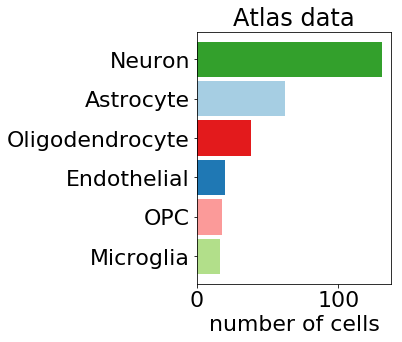

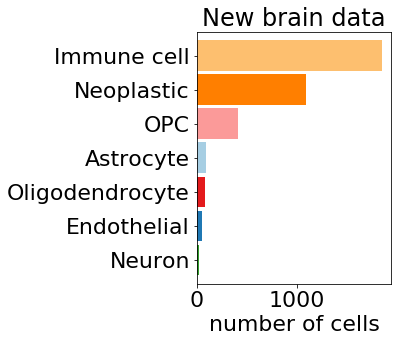

In [6]:
f,ax = plt.subplots(figsize=(6,5))
keys = atlas_avg_metadata.sort_index().index#sort_values('number_of_cells',ascending=False).index
lut = dict(zip(keys,sns.color_palette('Paired',len(keys))))
colors = atlas_avg_metadata.sort_values('number_of_cells').index.map(lut)
atlas_avg_metadata.sort_values('number_of_cells')['number_of_cells'].plot.barh(width=.9,ax=ax,color=colors)
#plt.gca().invert_yaxis()
plt.title('Atlas data')
plt.xlabel('number of cells')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig(savedir+'/Figure_2C_top.png')
f.savefig(savedir+'/Figure_2C_top.pdf')

additional_classes = list(set(GBM_meta['Cell_type']).difference(set(atlas_avg_metadata.index)))
lut.update({additional_classes[0]:sns.color_palette('Paired',8)[6]})
lut[additional_classes[1]] = sns.color_palette('Paired',8)[7]

f,ax = plt.subplots(figsize=(6,5))
colors = GBM_meta['Cell_type'].value_counts().index.map(lut)
GBM_meta['Cell_type'].value_counts().plot.barh(width=.9,color=colors,ax=ax)
plt.gca().invert_yaxis()
plt.xlabel('number of cells')
plt.title('New brain data')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig(savedir+'/Figure_2C_bottom.png')
f.savefig(savedir+'/Figure_2C_bottom.pdf')
plt.show()

# Feature select using atlas averages

In [7]:
date = time.datenum_complete()
# make a lookup table to standardize cell type nomenclature of atlas and test data:
name_lut = {'Astocyte':'Astrocyte','Astrocyte':'Astrocyte','microglia':'Microglia','Vascular':'Endothelial'
       ,'Astrocytes':'Astrocyte','Oligodendrocyte':'Oligodendrocyte','Neurons':'Neuron'
       ,'Neoplastic':'Neoplastic','Immune cell':'Immune cell','OPC':'OPC','Neuron':'Neuron'}
kwds = {'atlas':'Darmanis_2015_nofetal',
         'n_features_per_cell_type':50,
         'n_features_overdispersed':600,
         'n_pcs':20,
         'n_neighbors':10,
         'n_neighbors_out_of_atlas':5,
         'weights_atlas_cells':20,
         'threshold_neighborhood':0.8,
         'resolution_parameter':0.001,
         'timestamp':date,
         'savedir':savedir,
         'CT_lut':name_lut
        }
tsnedf,celltypes,distance_matrix = noa.atlas_averages_to_tsnedf(GBM_meta,GBM_counttable,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


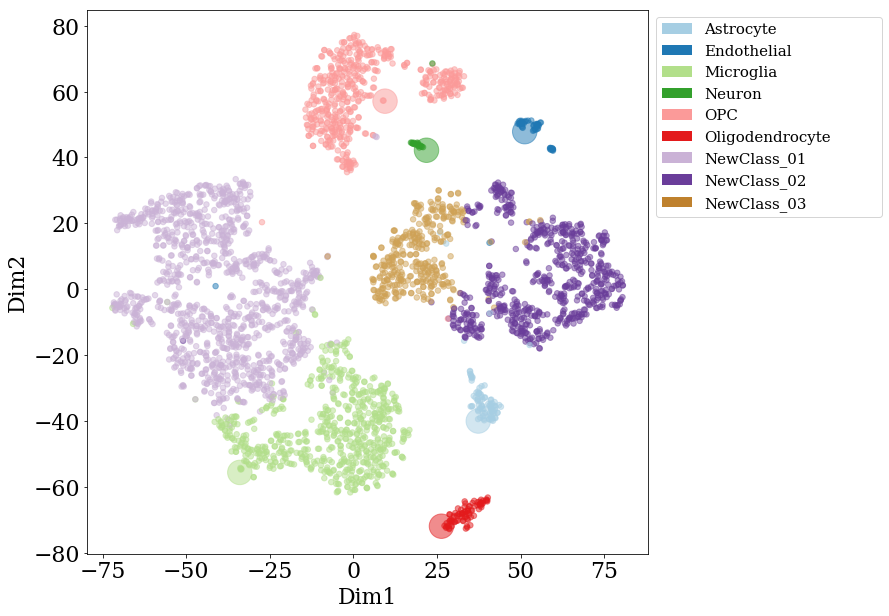

In [35]:
addl = len(celltypes)-8
if (addl % 2 == 0):
    added_colors = sns.color_palette('BrBG',addl)
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
elif addl>2:
    all_colors = sns.color_palette('BrBG',addl)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
else:
    added_colors = sns.color_palette('BrBG',3)[0]
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+[added_colors]
mainlut = dict(zip(celltypes,colors))
newcolor = tsnedf['new_membership'].map(mainlut)
weights = list(np.ones(6)*kwds['weights_atlas_cells']*30)+list(np.ones(len(tsnedf[6:]))*30)

f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('Dim1','Dim2',s=weights
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,celltypes,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
#plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/Figure_2B.png')
f.savefig(savedir+date+'/Figure_2B.pdf')
plt.show()

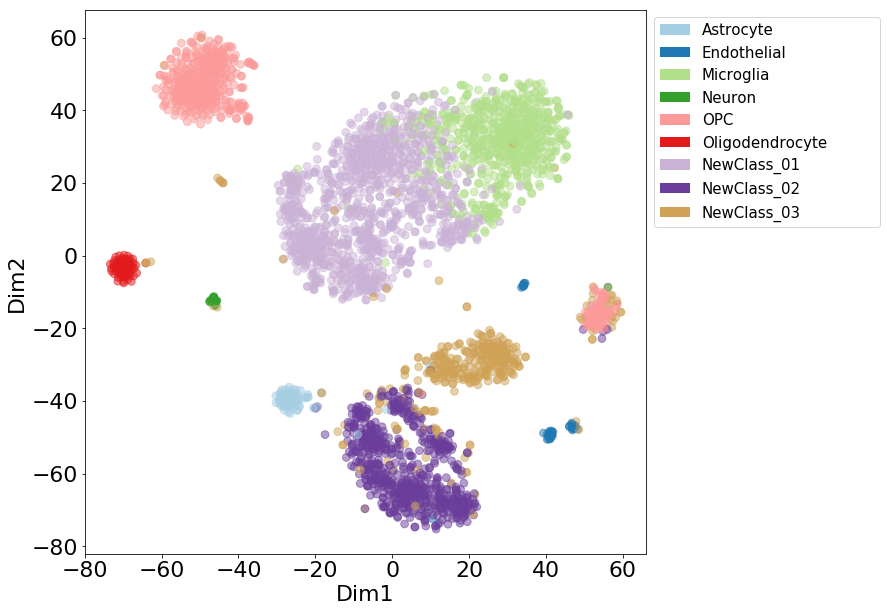

In [9]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE

newlut = dict(zip(celltypes,colors))#+sns.color_palette('BrBG',len(vals)-10)))
newcolor = GBM_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
#plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/Figure_S1_right.png')
f.savefig(savedir+date+'/Figure_S1_right.pdf')
plt.show()

# original annotations Glioblastoma data:

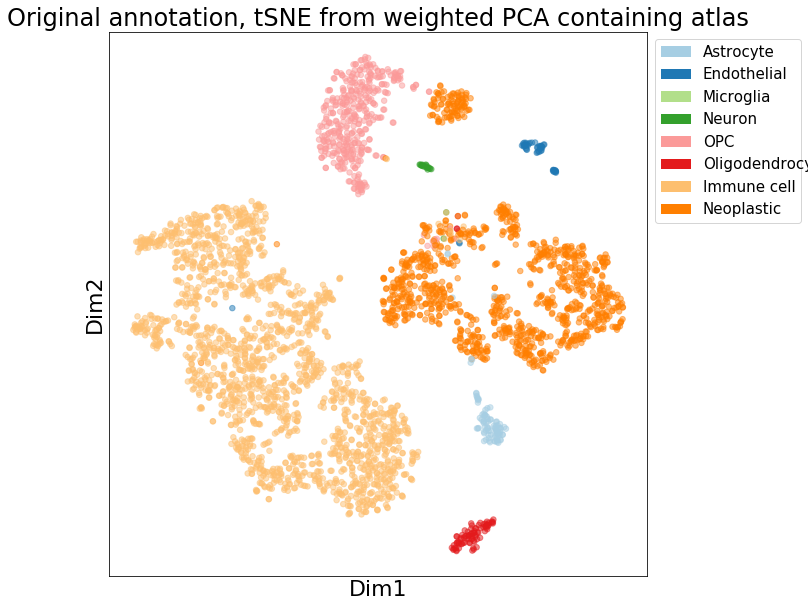

In [10]:
idx = GBM_meta.index
tsnedf.loc[idx,'original_membership'] = GBM_meta.loc[idx,'Cell_type']
keys = celltypes[:6]+list(set(GBM_meta['Cell_type'].unique()).difference(celltypes))
values = sns.color_palette('Paired',len(keys))
lut = dict(zip(keys,values))
colors = tsnedf[6:].original_membership.map(lut)

f = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(1,1)
ax = f.add_subplot(gs[0,0])
tsnedf[6:].plot.scatter('Dim1','Dim2',ax=ax,color=colors,s=30,alpha=.5)#,label=colors.keys)
for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
    plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original annotation, tSNE from weighted PCA containing atlas')
plt.gcf().subplots_adjust(left=.05,right=0.73)
plt.show()
f.savefig(savedir+date+'/Figure_2A.png')
f.savefig(savedir+date+'/Figure_2A.pdf')

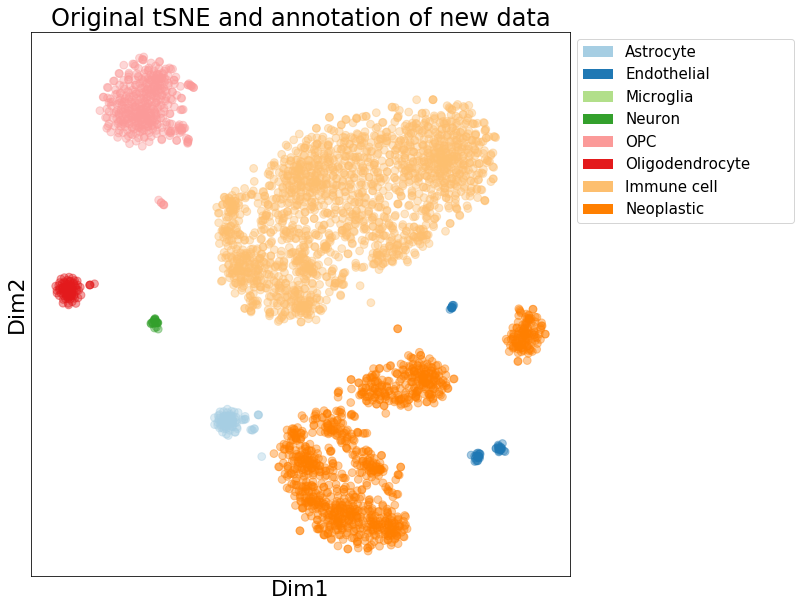

In [11]:
f,ax = plt.subplots(figsize=(11,10))
GBM_meta.plot.scatter('Dim1','Dim2',c=colors.loc[GBM_meta.index],ax=ax,alpha=.4,s=60)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original tSNE and annotation of new data')
plt.gcf().subplots_adjust(left=.05,right=0.73)
f.savefig(savedir+date+'/Figure_S1_left.png')
f.savefig(savedir+date+'/Figure_S1_left.pdf')
plt.show()

# Annotation using subsampling

In [12]:
kwds = {'atlas':'Darmanis_2015_nofetal',
         'n_features_per_cell_type':50,
         'n_features_overdispersed':600,
         'n_pcs':20,
         'n_neighbors':10,
         'n_neighbors_out_of_atlas':5,
         'weights_atlas_cells':20,
         'threshold_neighborhood':0.8,
         'resolution_parameter':0.001,
         'timestamp':date,
         'savedir':savedir,
         'CT_lut':name_lut
        }
tsnedf_sub, celltypes_sub = noa.atlas_subsamples_to_tsnedf(GBM_meta,GBM_counttable,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


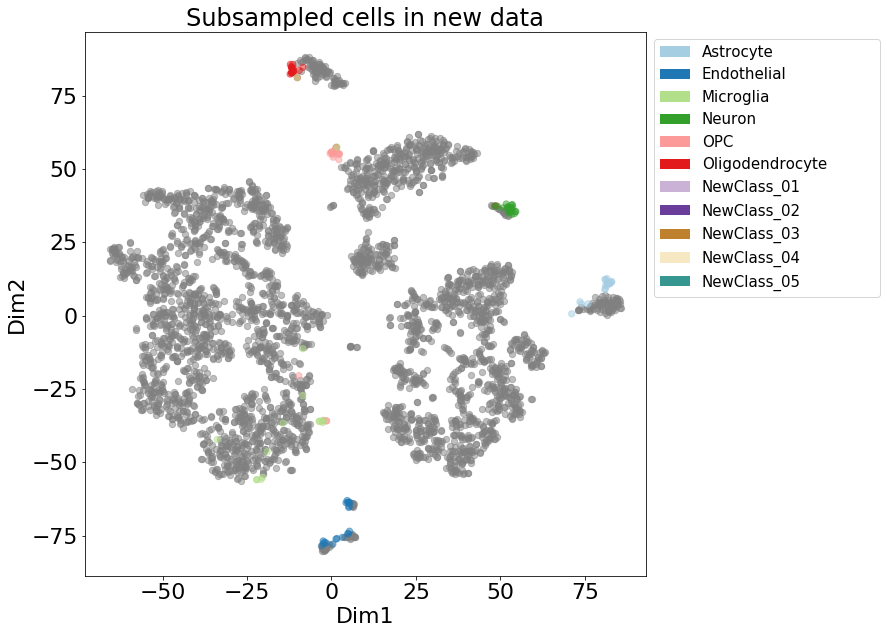

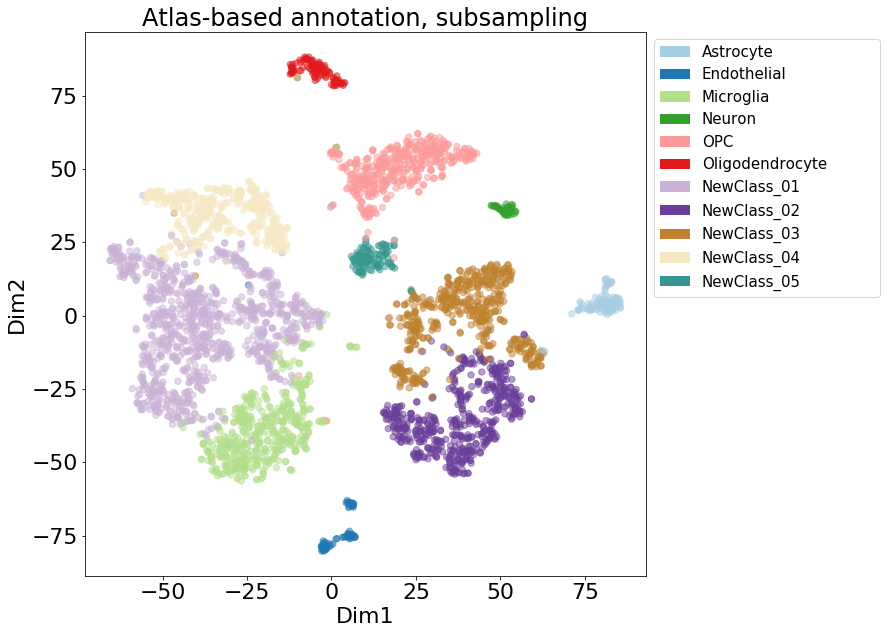

In [13]:
addl = len(celltypes_sub)-8
if addl % 2 == 0:
    added_colors = sns.color_palette('BrBG',addl)
else:
    all_colors = sns.color_palette('BrBG',addl+1)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]
colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors


newlut = dict(zip(celltypes_sub,colors))
newcolor = tsnedf_sub['new_membership'].map(newlut)
sub_cells = len(tsnedf_sub)-len(GBM_meta)

f,ax = plt.subplots(figsize=(12,10))
tsnedf_sub[sub_cells:].plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color='gray',ax=ax)
tsnedf_sub[:sub_cells].plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color=newcolor[:sub_cells],ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,celltypes_sub,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Subsampled cells in new data')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/Figure_S3_topLeft.png')
f.savefig(savedir+date+'/Figure_S3_topLeft.pdf')

f,ax = plt.subplots(figsize=(12,10))
tsnedf_sub.plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,celltypes_sub
           ,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation, subsampling')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/Figure_S3_topRight.png')
f.savefig(savedir+date+'/Figure_S3_topRight.pdf')
plt.show()

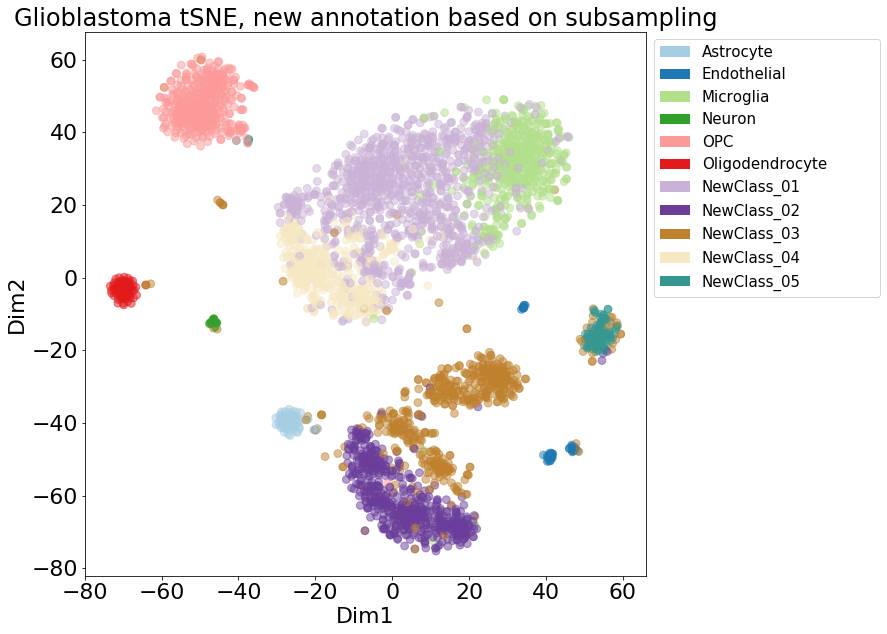

In [14]:
idx = tsnedf_sub[sub_cells:].index
GBM_meta.loc[idx,'new_membership_sub'] = tsnedf_sub.loc[idx]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(celltypes_sub,sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors))
newcolor = GBM_meta['new_membership_sub'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Glioblastoma tSNE, new annotation based on subsampling')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/Figure_S3_bottom.png')
f.savefig(savedir+date+'/Figure_S3_bottom.pdf')
plt.show()

In [15]:
tsnedf.to_csv(savedir+date+'/tsnedf_averaging_'+date+'.csv')
tsnedf_sub.to_csv(savedir+date+'/tsnedf_subsampling_'+date+'.csv')

# check annotation stability

[635 577 497 451 380 341  86  84  83  60  51  34  32  29  21  20  15  14
  11  10   9   8   6]


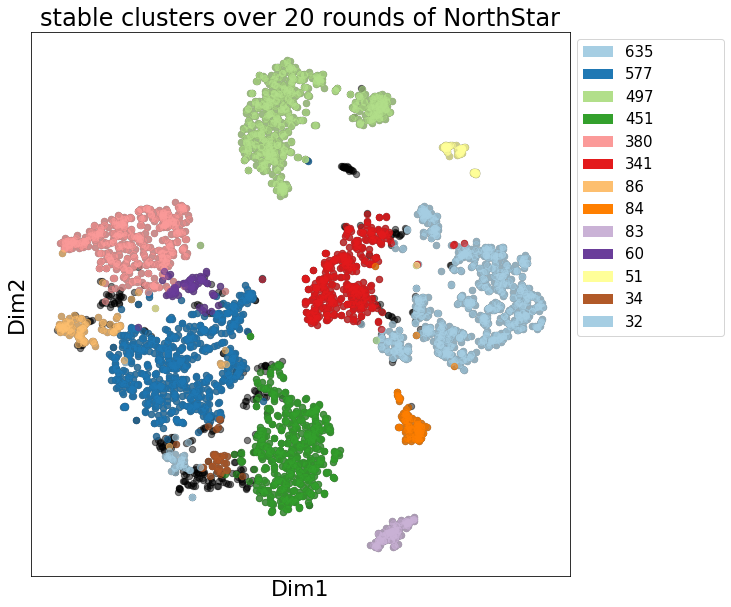

In [16]:
# uses same dict as above
dim = len(tsnedf)
trials = 20
b = c = np.ndarray([trials,dim,dim],np.int32)

for i in range(trials):
    annot = noa.atlas_averages_annotationOnly(GBM_meta,GBM_counttable,**kwds)
    df = pd.pivot_table(annot,values='class',index=annot.index,columns='new_membership',aggfunc=np.count_nonzero).fillna(0).copy()                     
    a = df.T.corr().values
    b[i][:][:] = a

average_df = pd.DataFrame(np.average(b,axis=0),index=df.index,columns=df.index)
drop_idx = average_df[(average_df[average_df==1].sum()==1)].index
stable_pairs = average_df.drop(drop_idx).drop(drop_idx,axis=1)
stablep = stable_pairs[stable_pairs==1].fillna(0)

# select groups with same size as value counts (this avoids me having to perform hierarchical clustering)
idx = stablep.sum().value_counts().index.astype(int)
val = stablep.sum().value_counts().values
df = pd.DataFrame(index=range(len(idx)), columns=['idx','val'])
df['idx'] = idx;df['val'] = val
groups = df[df.eq(df.iloc[:, 0], axis=0).all(1)==True].idx.values

idxs = []
for cluster in groups:
    idxs.append(list(stablep[stablep.sum()==cluster].index))
clusterdict = dict(zip(groups,idxs))
print(groups)
groupi = groups[:13] # take the 13 largest groups

values = sns.color_palette('Paired',len(groupi))
lut = dict(zip(groupi,values))

f,ax = plt.subplots(figsize=(11,10))
tsnedf.plot.scatter('Dim1','Dim2',ax=ax,color='k',s=2*20,alpha=.5)
for group in groupi:
    idxes = clusterdict[group]
    tsnedf.loc[idxes].plot.scatter('Dim1','Dim2',ax=ax,color=lut[group],s=40,alpha=.6)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('stable clusters over '+str(trials)+' rounds of NorthStar')
plt.gcf().subplots_adjust(left=.05,right=0.73)
f.savefig(savedir+date+'/Figure_S2_middle.png')
f.savefig(savedir+date+'/Figure_S2_middle.pdf')
plt.show()

In [17]:
cluster_pair_df = noa.make_pairdf(1-average_df,2,tsnedf,'Dim')

---------------------------------------
Making list of edges with -100% correlation and up
Max 2 edges per cell.
Found 3595 edges.
---------------------------------------


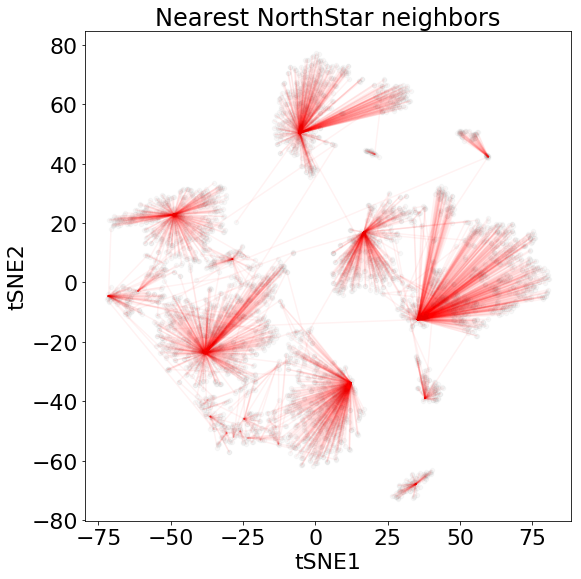

In [18]:
f,ax = plt.subplots(figsize=(10,10))
tsnedf.plot.scatter('Dim1','Dim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in cluster_pair_df.index:
    xy1 = tsnedf.loc[cluster_pair_df.loc[pair,0]][['Dim1','Dim2']]
    xy2 = tsnedf.loc[cluster_pair_df.loc[pair,1]][['Dim1','Dim2']]
    ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.05,c='r')

#plt.yticks([]);plt.xticks([])
plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Nearest NorthStar neighbors')

plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig(savedir+date+'/Figure_S2_right.png')
f.savefig(savedir+date+'/Figure_S2_right.pdf')

# distance matrix features

In [19]:
pairdf = noa.make_pairdf(pd.DataFrame(distance_matrix),5,tsnedf,'Dim')

---------------------------------------
Making list of edges with -100% correlation and up
Max 5 edges per cell.
Found 14380 edges.
---------------------------------------


In [20]:
pairdf.head()

,0,1,edge_type,correlation,distance,edge_length
0,0,668,inter_class,0.658473,0.341527,148.694778
1,0,1173,intra_class,0.562960,0.437040,0.911591
2,0,22,intra_class,0.561715,0.438285,7.738852
3,0,1300,intra_class,0.556329,0.443671,4.341481
4,1,599,intra_class,0.680882,0.319118,0.587470


In [21]:
pairdf.edge_type.value_counts()

intra_class    14068
inter_class      312
Name: edge_type, dtype: int64

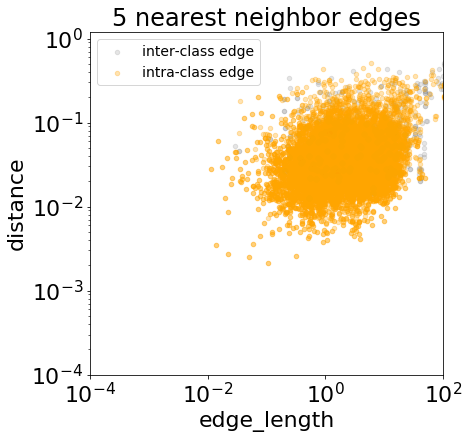

In [22]:
lut = {'intra_class':'orange','inter_class':'gray'}
cols = pairdf['edge_type'].map(lut)
f,ax = plt.subplots()
pairdf[pairdf['edge_type'].str.contains('inter')].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color='gray',label='inter-class edge',ax=ax)
pairdf[pairdf['edge_type'].str.contains('intra')].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color='orange',label='intra-class edge',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
plt.show()

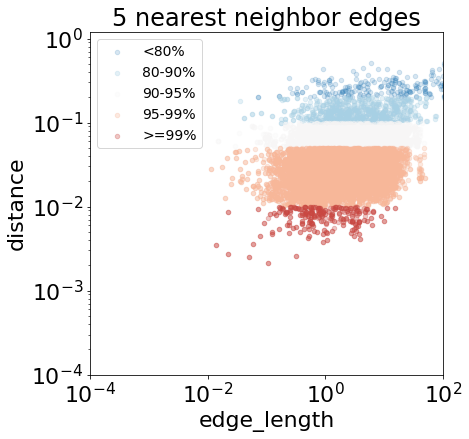

In [23]:
colors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots()
pairdf[pairdf['correlation']<.8].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color=colors[0],label='<80%',ax=ax)
pairdf[(pairdf['correlation']<.9)&(pairdf['correlation']>=.8)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[1],label='80-90%',ax=ax)
pairdf[(pairdf['correlation']<.95)&(pairdf['correlation']>=.9)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[2],label='90-95%',ax=ax)
pairdf[(pairdf['correlation']<.99)&(pairdf['correlation']>=.95)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[3],label='95-99%',ax=ax)
pairdf[pairdf['correlation']>=.99].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[4],label='>=99%',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
plt.show()

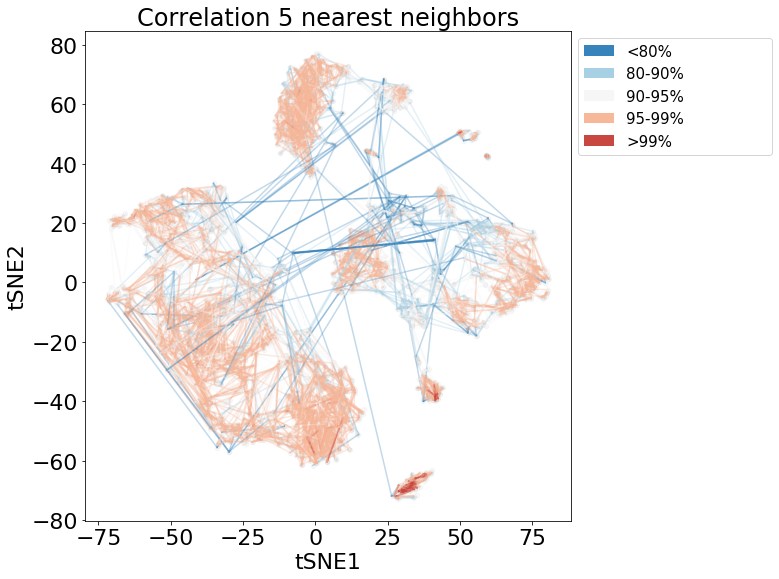

In [24]:
colors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots(figsize=(10,10))
tsnedf.plot.scatter('Dim1','Dim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in pairdf.index:
    xy1 = tsnedf.iloc[pairdf.loc[pair,0]][['Dim1','Dim2']]
    xy2 = tsnedf.iloc[pairdf.loc[pair,1]][['Dim1','Dim2']]
    corr = pairdf.loc[pair,'correlation']
    if corr<.8:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[0])
    elif (corr>=.8) & (corr<.9):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[1])
    elif (corr>=.9) & (corr<.95):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[2])
    elif (corr>=.95) & (corr<.99):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[3])
    elif corr>=.99:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[4])
#plt.yticks([]);plt.xticks([])
handles = ['<80%','80-90%','90-95%','95-99%','>99%']
labs = [f for f in colors]
dictcorr = dict(zip(handles,labs))
for x,y in dictcorr.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handle, labels = ax.get_legend_handles_labels()
    
plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Correlation 5 nearest neighbors')
plt.legend(handle,handles, bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig(savedir+date+'/Figure_S2_left.png')
f.savefig(savedir+date+'/Figure_S2_left.pdf')

# Sankey Diagram

In [27]:
imp.reload(nosa)
idx = GBM_meta.index
tsnedf.loc[idx,'original_membership'] = GBM_meta.loc[idx,'Cell_type']
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
values = ['original_membership','new_membership','Figure_2D'
        ,savedir+date+'/',True]
kw = dict(zip(keys,values))
# change the order of col_order numbers to change the sankey right column ordering:
#col_order = range(len(tsnedf['new_membership'].unique()))
l,r = nosa.sankey(tsnedf[6:],column_order=None,**kw)

# Make DotPlot

{'Astrocyte': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Endothelial': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Microglia': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'Neuron': (0.2, 0.6274509803921569, 0.17254901960784313),
 'NewClass_01': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 'NewClass_02': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 'NewClass_03': (0.7490196078431373, 0.5058823529411764, 0.17647058823529413),
 'NewClass_04': (0.9647058823529412, 0.9098039215686274, 0.7647058823529411),
 'NewClass_05': (0.207843137254902, 0.592156862745098, 0.5607843137254902),
 'OPC': (0.984313725490196, 0.6039215686274509, 0.6),
 'Oligodendrocyte': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745)}

In [36]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
values = ['original_membership','new_membership','Figure_2E'
        ,savedir+date+'/',False]
kw = dict(zip(keys,values))
matrix_feature_selected = pd.read_csv(savedir+date+'/feature_selected_matrix_'+date+'.csv',index_col=0)
genePanel,rows,cols,DEGs,avg = ndot.make_dotplot(matrix_feature_selected,tsnedf,3,list(mainlut.values()),**kw)

/Users/bojk/Google Drive/QuakeLab/minimeta_pyfiles/northstar_dotplot.py:164: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(xgrid,np.ones(len(xgrid))*i,s=np.log2(temp).multiply(70),c=colorlist,alpha=.8)
/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
